In [28]:
"""
Multi-Agent System with Real Tools (Tavily Search, LLM Summarization)

This notebook updates the multi-agent LangGraph example to integrate:
1.  **Real Web Search:** Using the Tavily Search API instead of mocked results.
2.  **LLM-Powered Summarization:** Leveraging an LLM (OpenAI's chat model) for intelligent summarization.
3.  **Clear Agents vs. Tools Distinction:** Separating tool definitions from agent logic.

Audience: Developers looking to build more capable multi-agent systems by
integrating external APIs and using LLMs for complex tasks, while
understanding the architectural roles of agents and tools.

Key Learning Points:
* Practical integration of real-world tools (Tavily, LLM) into LangGraph agents.
* Best practices for separating tool functionality from agent decision-making.
* Asynchronous execution (`async`/`await`) for external API calls.
* Role of LLMs in summarization within a multi-agent pipeline.
"""

"\nMulti-Agent System with Real Tools (Tavily Search, LLM Summarization)\n\nThis notebook updates the multi-agent LangGraph example to integrate:\n1.  **Real Web Search:** Using the Tavily Search API instead of mocked results.\n2.  **LLM-Powered Summarization:** Leveraging an LLM (OpenAI's chat model) for intelligent summarization.\n3.  **Clear Agents vs. Tools Distinction:** Separating tool definitions from agent logic.\n\nAudience: Developers looking to build more capable multi-agent systems by\nintegrating external APIs and using LLMs for complex tasks, while\nunderstanding the architectural roles of agents and tools.\n\nKey Learning Points:\n* Practical integration of real-world tools (Tavily, LLM) into LangGraph agents.\n* Best practices for separating tool functionality from agent decision-making.\n* Asynchronous execution (`async`/`await`) for external API calls.\n* Role of LLMs in summarization within a multi-agent pipeline.\n"

In [43]:
!pip install openai langchain langgraph pandas faiss-cpu langchain_openai langchain-community tavily-python langchain-tavily

In [77]:
import asyncio
import pandas as pd
import os
from langgraph.graph import StateGraph, END
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [3]:
# --- Setup: Create Sample Data and Vector Store ---
csv_file_name = "stackoverflow_qa.csv"
if not os.path.exists(csv_file_name):
    print("Creating sample Stack Overflow dataset...")
    data = [
        {"question": "How do I reverse a list in Python?", "answer": "Use list.reverse() or list[::-1]."},
        {"question": "What is a lambda function in Python?", "answer": "A lambda function is an anonymous function defined with the lambda keyword."},
        {"question": "How to install a package using pip?", "answer": "Run 'pip install package_name' in your terminal."},
        {"question": "What is the difference between a list and a tuple?", "answer": "Lists are mutable, tuples are immutable."},
        {"question": "How can I read a file in Python?", "answer": "Use open('filename') and read() or readline() methods."}
    ]
    df_init = pd.DataFrame(data)
    df_init.to_csv(csv_file_name, index=False)
    print("Sample Stack Overflow dataset created!")

df = pd.read_csv(csv_file_name)
qa_pairs = df.to_dict(orient="records")
docs = [f"Q: {row['question']}\nA: {row['answer']}" for row in qa_pairs]

In [4]:
from google.colab import userdata
openai_token = userdata.get('OPENAI_API_KEY')
tavily_api_key = userdata.get('TAVILY_API_KEY')
import os
os.environ['OPENAI_API_KEY'] = openai_token
os.environ['TAVILY_API_KEY'] = tavily_api_key

In [95]:
# Initialize LLM and Embeddings (for KB and Summarization)
try:
    llm = ChatOpenAI(model="gpt-4o", temperature=0.2) # Using a capable LLM for summarization
    embeddings = OpenAIEmbeddings()
    print("LLM and Embeddings initialized.")
except Exception as e:
    print(f"Error initializing LLM/Embeddings: {e}")
    print("Please ensure OPENAI_API_KEY environment variable is set.")
    exit() # Exit if we can't initialize critical components

vectorstore = FAISS.from_texts(docs, embeddings)
print("FAISS vector store initialized.")

LLM and Embeddings initialized.
FAISS vector store initialized.


In [6]:
# --- Distinction: Define TOOLS (External Capabilities) ---
# Tools are specific functions or API wrappers that perform atomic actions.
# Agents will 'call' or 'use' these tools.

In [96]:
# Tool 1: Knowledge Base Retrieval Tool
# This tool encapsulates the logic for searching our local FAISS vector store.
async def retrieve_from_kb_tool(question: str) -> str | None:
    """Retrieves a relevant answer from the local knowledge base."""
    print(f"  [Tool: KB Retrieval]: Searching for '{question}'...")
    # Simulate a small I/O delay for a local lookup
    await asyncio.sleep(0.1)
    results = vectorstore.similarity_search_with_score(f"Q: {question}", k=1)
    if results and results[0][1] < 0.5: # Use a lower score for better match in FAISS (score is distance, lower is better)
        doc = results[0][0]
        print(f"  [Tool: KB Retrieval]: Found match with score {results[0][1]:.2f}")
        return doc.page_content.split("A:")[-1].strip()
    print("  [Tool: KB Retrieval]: No strong match found.")
    return None

In [133]:
# Tool 2: Tavily Web Search Tool
# This tool uses the TavilySearch class from langchain_tavily.
# It makes a real API call to Tavily.
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(max_results=3) # Limit results to 3 for brevity and cost
print("TavilySearch tool initialized.")

TavilySearch tool initialized.


In [134]:
# Tool 3: LLM Summarization Tool
# This tool uses our ChatOpenAI LLM to summarize given texts.
async def llm_summarize_tool(question: str, kb_answer: str | None, web_results: str | None) -> str:
    """
    Summarizes information from the knowledge base and web search using an LLM.
    """
    print("  [Tool: LLM Summarization]: Summarizing information...")
    # Define the prompt for summarization
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system", "You are an expert assistant. Summarize the provided information to answer the user's question concisely and accurately. If no information is provided, state that you couldn't find an answer."),
            ("user", "Question: {question}\n\nKnowledge Base Answer: {kb_answer}\n\nWeb Search Results: {web_results}\n\nProvide a comprehensive answer based on the available information:")
        ]
    )

    # Create an LLM chain for summarization
    summarization_chain = prompt_template | llm | StrOutputParser()

    # Invoke the LLM chain asynchronously
    # This is an I/O operation and should be awaited.
    summary = await summarization_chain.ainvoke({
        "question": question,
        "kb_answer": kb_answer if kb_answer else "None provided.",
        "web_results": web_results if web_results else "None provided."
    })
    print("  [Tool: LLM Summarization]: Summary generated.")
    return summary

In [135]:
# Tool 4: Logger Tool
# Simple tool to log unanswered questions to a file.
async def log_unanswered_tool(question: str, log_file="unanswered_questions_real_tools.txt") -> str:
    """Logs an unanswered question to a file."""
    print(f"  [Tool: Logger]: Logging unanswered question: '{question}'...")
    await asyncio.sleep(0.05) # Simulate file write delay
    with open(log_file, "a") as f:
        f.write(question + "\n")
    print(f"  [Tool: Logger]: Question logged to '{log_file}'.")
    return "Question logged for human review."

In [142]:
from typing import TypedDict, Optional

class AgentState(TypedDict):
    """
    Represents the state of the multi-agent system for a single run.
    This dictates what data is passed between nodes in the LangGraph.
    """
    question: str
    kb_answer: Optional[str]
    web_results: Optional[str]
    final_answer: Optional[str]
    found_in_kb: bool
    web_search_performed: bool
    logged: bool
    final_answer_found: bool # Add this as it's used in conditional edges

In [12]:
# --- Define AGENTS (Decision-Making Nodes in LangGraph) ---
# Agents orchestrate tool usage and decide the next step in the workflow.

In [137]:
# Agent 1: Knowledge Base Agent
# Attempts to find an answer in our local FAISS vector store using `retrieve_from_kb_tool`.
async def knowledge_base_agent_node(state: AgentState) -> AgentState:
    print(f"\n[Agent: KnowledgeBase]: Current state keys: {state.keys()}")
    print(f"[Agent: KnowledgeBase]: Full state: {state}")
    question = state["question"]
    print(f"[Agent: KnowledgeBase]: Receiving question: '{question}'")

    # Agent calls the KB retrieval tool
    kb_answer = await retrieve_from_kb_tool(question)

    state["kb_answer"] = kb_answer
    if kb_answer:
        state["found_in_kb"] = True
        print("[Agent: KnowledgeBase]: Found answer in KB.")
    else:
        state["found_in_kb"] = False
        print("[Agent: KnowledgeBase]: No strong match in KB.")
    return state

In [138]:
# Agent 2: Web Search Orchestrator Agent
# Decides whether to perform a web search and executes `tavily_search_tool`.
# Renamed to reflect its role as an orchestrator of the web search tool.
async def web_search_orchestrator_agent_node(state: AgentState) -> AgentState:
    # This agent only runs if a good answer wasn't found in the KB
    if state["found_in_kb"]:
        print("\n[Agent: WebSearchOrchestrator]: Skipping web search as KB had an answer.")
        return state

    question = state["question"]
    print(f"\n[Agent: WebSearchOrchestrator]: Decided to perform web search for: '{question}'")
    state["web_search_performed"] = True

    try:
        # --- DEBUGGING STEP 1: Inspect the raw search_results ---
        print(f"[Agent: WebSearchOrchestrator]: Calling TavilySearch for question: '{question}'")
        search_results_raw = await tavily_search_tool.ainvoke(question)
        print(f"[Agent: WebSearchOrchestrator]: Raw Tavily Search results type: {type(search_results_raw)}")
        print(f"[Agent: WebSearchOrchestrator]: Raw Tavily Search results value: {search_results_raw}")


        # Ensure search_results is always a list of dictionaries
        if isinstance(search_results_raw, dict):
            search_results = [search_results_raw]
            print("[Agent: WebSearchOrchestrator]: Wrapped single dict result into a list.")
        elif isinstance(search_results_raw, list):
            search_results = search_results_raw
            print(f"[Agent: WebSearchOrchestrator]: Received a list of {len(search_results)} results.")
        else:
            print(f"[Agent: WebSearchOrchestrator]: Unexpected type for search_results_raw: {type(search_results_raw)}. Assuming no valid results.")
            search_results = [] # Treat as no results

        # --- DEBUGGING STEP 2: Inspect individual results after standardization ---
        if not search_results:
            print("[Agent: WebSearchOrchestrator]: No results found after standardization.")
        else:
            print(f"[Agent: WebSearchOrchestrator]: Processing {len(search_results)} standardized results.")
            for i, res in enumerate(search_results):
                print(f"  Result {i+1} Type: {type(res)}, Keys: {res.keys() if isinstance(res, dict) else 'N/A'}")
                print(f"    URL: {res.get('url', 'N/A')}")
                print(f"    Content snippet: {res.get('content', 'No content available.')[:100]}...") # Print first 100 chars
                print(f"    Title: {res.get('title', 'N/A')}") # Check if title is available

        # Convert list of dicts to a readable string for the LLM
        # Use .get() to safely access keys and provide default empty strings if keys are missing
        formatted_results = "\n\n".join([
            f"Source: {res.get('url', 'N/A')}\nTitle: {res.get('title', 'No Title Available')}\nContent: {res.get('content', 'No content available.')}"
            for res in search_results
        ])

        state["web_results"] = formatted_results
        print(f"[Agent: WebSearchOrchestrator]: Web search completed. Retrieved {len(search_results)} results. Formatted length: {len(formatted_results)} characters.")
        if not formatted_results:
            print("[Agent: WebSearchOrchestrator]: Formatted results are empty.")

    except Exception as e:
        print(f"[Agent: WebSearchOrchestrator]: An unexpected error occurred during web search: {e}")
        state["web_results"] = f"Error during web search: {e}" # Store the actual error for debugging if needed

    return state

In [139]:
# Agent 3: Summarization Agent
# Takes the retrieved answers and uses the `llm_summarize_tool` to synthesize a final answer.
async def summarization_agent_node(state: AgentState) -> AgentState:
    print("\n[Agent: Summarization]: Receiving inputs for summarization.")

    question = state["question"]
    kb_answer = state["kb_answer"]
    web_results = state["web_results"]

    # Agent calls the LLM summarization tool
    final_summary = await llm_summarize_tool(question, kb_answer, web_results)

    state["final_answer"] = final_summary

    # Simple check if the LLM actually found an answer or just stated it couldn't
    if "couldn't find" in final_summary.lower() or "no sufficient answer" in final_summary.lower():
        state["final_answer_found"] = False
        print("[Agent: Summarization]: LLM indicated no sufficient answer.")
    else:
        state["final_answer_found"] = True
        print("[Agent: Summarization]: Final answer summarized.")

    return state

In [140]:
# Agent 4: Logger Agent
# Uses the `log_unanswered_tool` if no sufficient answer was found.
async def logger_agent_node(state: AgentState) -> AgentState:
    # This agent only runs if the summarization agent couldn't find a sufficient answer
    if state.get("final_answer_found", False):
        print("\n[Agent: Logger]: Skipping logging as a sufficient answer was found.")
        state["logged"] = False
        return state

    question = state["question"]
    print(f"\n[Agent: Logger]: Decided to log unanswered question: '{question}'")

    # Agent calls the logging tool
    log_message = await log_unanswered_tool(question)
    state["logged"] = True
    # Overwrite final_answer with log message if we are here because no answer was found
    state["final_answer"] = log_message
    print("[Agent: Logger]: Question logged.")
    return state

In [143]:
# --- Build the LangGraph for the Multi-Agent System ---

# Define the graph using our AgentState
graph = StateGraph(AgentState)

In [144]:
# Add nodes for each agent function
# Note: These are the AGENTS (decision makers), not the tools directly.
graph.add_node("knowledge_base_lookup", knowledge_base_agent_node)
graph.add_node("web_search_orchestration", web_search_orchestrator_agent_node)
graph.add_node("summarize_results", summarization_agent_node)
graph.add_node("log_unanswered", logger_agent_node)

In [145]:
# Set the entry point for the graph
graph.set_entry_point("knowledge_base_lookup")

# Define conditional edges based on whether KB found an answer
graph.add_conditional_edges(
    "knowledge_base_lookup",
    # If KB found an answer, go directly to summarization
    lambda state: "summarize_results" if state["found_in_kb"] else "web_search_orchestration",
    {"summarize_results": "summarize_results", "web_search_orchestration": "web_search_orchestration"}
)

# After web search, always proceed to summarization
graph.add_edge("web_search_orchestration", "summarize_results")

# After summarization, conditionally end or log if no final answer was generated by LLM
graph.add_conditional_edges(
    "summarize_results",
    # Check the flag set by the summarization agent
    lambda state: END if state.get("final_answer_found", False) else "log_unanswered",
    {END: END, "log_unanswered": "log_unanswered"}
)

# After logging, the process ends
graph.add_edge("log_unanswered", END)

In [146]:
# Compile the graph
multi_agent_qa_graph = graph.compile()
print("\nLangGraph compiled with real tools and distinct agents/tools.")


LangGraph compiled with real tools and distinct agents/tools.


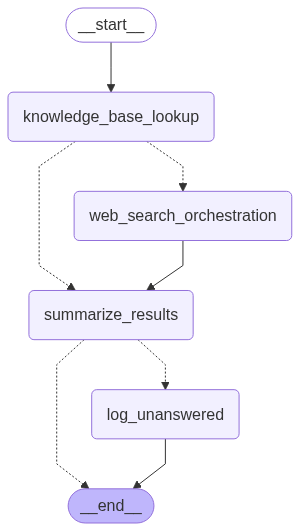

In [147]:
multi_agent_qa_graph

In [148]:
# --- Main Asynchronous Execution Function ---

async def ask_multi_agent_question(question: str):
    initial_state = {"question": question,
                     "kb_answer": None,
                     "web_results": None,
                     "final_answer": None,
                     "found_in_kb": False,
                     "web_search_performed": False,
                     "logged": False,
                     "final_answer_found": False} # Initialize all keys!
    print(f"\n--- Starting multi-agent process for: '{question}' ---")
    final_state = await multi_agent_qa_graph.ainvoke(initial_state)
    print(f"--- Multi-agent process finished for: '{question}' ---")
    return final_state["final_answer"]

In [149]:
# --- Command-line Interface to interact with the Multi-Agent System ---

async def main():
    print("Welcome to the Enhanced Multi-Agent Stack Overflow Assistant!")
    print("Type your Python question, or 'exit' to quit.")
    print("\nNote: This now uses Tavily Search for web queries and an LLM for summarization.")
    print("Ensure OPENAI_API_KEY and TAVILY_API_KEY are set as Colab secrets.")

    while True:
        user_q = input("\nQ: ")
        if user_q.lower() == "exit":
            break

        answer = await ask_multi_agent_question(user_q)
        print(f"\nA: {answer}")

In [150]:
# --- Entry point for running the asynchronous application ---
if __name__ == "__main__":
    # asyncio.run(main()) # This will cause issues in environments like Colab that already have a running event loop
    # Instead, directly await the main coroutine
    await main()

Welcome to the Enhanced Multi-Agent Stack Overflow Assistant!
Type your Python question, or 'exit' to quit.

Note: This now uses Tavily Search for web queries and an LLM for summarization.
Ensure OPENAI_API_KEY and TAVILY_API_KEY are set as Colab secrets.

Q: how to fix skew in spark jobs?

--- Starting multi-agent process for: 'how to fix skew in spark jobs?' ---

[Agent: KnowledgeBase]: Current state keys: dict_keys(['question', 'kb_answer', 'web_results', 'final_answer', 'found_in_kb', 'web_search_performed', 'logged', 'final_answer_found'])
[Agent: KnowledgeBase]: Full state: {'question': 'how to fix skew in spark jobs?', 'kb_answer': None, 'web_results': None, 'final_answer': None, 'found_in_kb': False, 'web_search_performed': False, 'logged': False, 'final_answer_found': False}
[Agent: KnowledgeBase]: Receiving question: 'how to fix skew in spark jobs?'
  [Tool: KB Retrieval]: Searching for 'how to fix skew in spark jobs?'...
  [Tool: KB Retrieval]: No strong match found.
[Agent: